In [9]:
from DataProcessing import Data
import tensorflow as tf
from tensorflow import keras as keras

# 1. Get Data

## 1.1. Get data from folder

In [10]:
d = Data()
d.get_index_names()

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']


['AAPL',
 'ORCL',
 'GOOGL',
 'AMZN',
 'BK',
 'LIFE',
 'T',
 'XOM',
 'VHM',
 'CTR',
 'FPT',
 'MBB']

In [11]:
chosen_index = 'VHM'
df = d.get_data(chosen_index).drop(['Date','Volume'],axis=1)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'RSI', 'MFI', 'EMA', 'SO', 'MACD',
       'Next Day Price'],
      dtype='object')

In [12]:
df.shape
X = df[df.columns[0:9]].values
Y = df[df.columns[9]].values

TRAIN_PERCENT = 0.7
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

# 2. Train model

In [13]:
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.LSTM(100,input_shape=(None,9),return_sequences=True,activation='relu'))
rnn_model.add(keras.layers.Dense(1))
rnn_model.summary()

f:\bk_ky6\ML\project\stock-market-prediction\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, None, 100)      │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 1)        │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,101 (172.27 KB)

 Trainable params: 44,101 (172.27 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [15]:
num_epochs = 400
batch_size = 1
learning_rate = 0.001
Adam = keras.optimizers.Adam(learning_rate)
MSE = keras.losses.MeanSquaredError()

## 2.1. Train

In [16]:
rnn_model.compile(optimizer=Adam,loss=MSE)
rnn_model.fit(X_train,Y_train,epochs=num_epochs,validation_data=(X_test,Y_test),batch_size=batch_size)

Epoch 1/400


509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1481954304.0000 - val_loss: 9053434.0000
Epoch 2/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3825910.0000 - val_loss: 8734228.0000
Epoch 3/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3543553.7500 - val_loss: 8290787.0000
Epoch 4/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6007914.5000 - val_loss: 7852629.5000
Epoch 5/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4087348.0000 - val_loss: 7893881.0000
Epoch 6/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3831349.2500 - val_loss: 7647826.0000
Epoch 7/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3628567.2500 - val_loss: 8201464.5000
Epoch 8/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3725058.5000 - val_loss: 7394965.5000
Epoch 9/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4000180.2500 - val_loss: 7263456.0000
Epoch 10/400
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3665297.5000 - val_loss: 7132706.5000
Epoch 11/400
509/5

## 2.2. Test

In [17]:
Y_pred = rnn_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [18]:
Y_pred.shape

(219, 1, 1)

In [19]:
Y_pred = Y_pred.reshape(219)

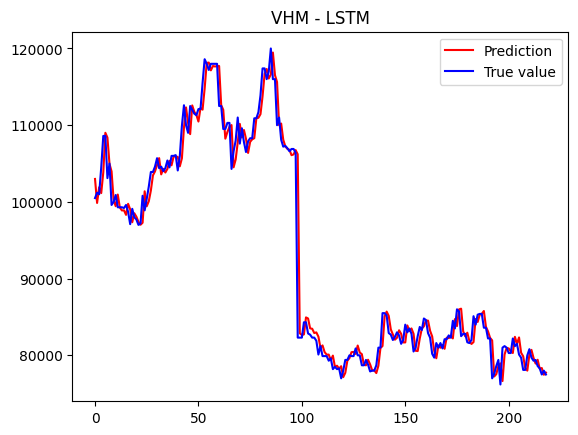

In [20]:
import matplotlib.pyplot as plt
plt.plot(Y_pred,c='red',label = 'Prediction')
plt.plot(Y_test,c='blue',label = 'True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - LSTM')
plt.show()

## 2.3. Evaluate

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 5578699.968043218
Mean Absolute Error: 1336.3659389269405
R-squared: 0.9706857001551247
